In [1]:
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import math
from numpy import quantile, where, random
from sklearn.preprocessing import StandardScaler
from datetime import date, datetime
import matplotlib.pyplot as plt
import time
from IPython.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

In [7]:
!jt -t chesterish

In [2]:
def generate_features(X, Y, window=100):
    """
        Function for generating new data features
        
        Parameters
        ----------
            X : List
                X values
            Y : List
                Y values
            window : int
                count of values (left | right) to take properties of
                
        Returns
        -------
            features : np.array
                matrix with X, Y values and new features
    """
    
    # count of original features
    num_fet = 2
    # count of additional features per window
    num_adv_fet = 4
    # number of windows for each value
    num_windows = 4
    
    features = []
    
    # generate features for the beginning
    for i in range(window):
        new_row = [X[i]]
        
        new_row.append(Y[i])
        
        for j in range(num_adv_fet * num_windows // 2):
            new_row.append(0)
            
        for slc in [Y[i:i + window // 2], Y[i:i + window]]:
            new_row.append(np.mean(slc))
            new_row.append(np.median(slc))
            new_row.append(np.std(slc))
            new_row.append(np.var(slc))
    
        features.append(new_row)
    
    # generate features for the middle
    for i in range(window, window + len(Y[window:-window])):
        new_row = [X[i]]
        
        new_row.append(Y[i])
        
        for slc in [Y[i - window:i], Y[i - window // 2:i], Y[i:i + window // 2], Y[i:i + window]]:
            new_row.append(np.mean(slc))
            new_row.append(np.median(slc))
            new_row.append(np.std(slc))
            new_row.append(np.var(slc))
        
        features.append(new_row)
    
    # generate features for the end
    for i in range(window):
        new_row = [X[-window:][i]]
        
        new_row.append(Y[-window:][i])
        
        for slc in [Y[-(2 * window) + i:-window + i], Y[-int(window + window // 2) + i:-window + i]]:
            new_row.append(np.mean(slc))
            new_row.append(np.median(slc))
            new_row.append(np.std(slc))
            new_row.append(np.var(slc))
        
        for j in range(num_adv_fet * num_windows // 2):
            new_row.append(0)
            
        features.append(new_row)
        
    # so that for the first N values there's no N values on the left and for the last N values there's no N values on the right
    # these features will be taken from their neighbours
    features = np.matrix(features)
    features[:window, 2:num_fet + num_adv_fet * num_windows // 2] = features[window:2 * window, 2:num_fet + num_adv_fet * num_windows // 2]
    features[-window:, num_fet + num_adv_fet * num_windows // 2:] = features[-(2 * window):-window, num_fet + num_adv_fet * num_windows // 2:]
        
    return np.array(features)

In [4]:
def hallway(data, glob_value, hallway_length='std', hall_rise=False):
    """
        Function for generating a hallway for outputs
        
        Parameters
        ----------
            data : np.array
                original data
            hallway_length : string
                parameter for hallway length: median std or median var
            hall_rise : boolean
                parameter for hallway size stretching in cases where local std (var) is lower then global std (var)
                
        Returns
        -------
            bot_hall : np.array
                bottom edge for clean detecting data
            top_hall : np.array
                top edge for clean detecting data
    """
    
    # count of original features
    num_fet = 2
    # count of additional features per window
    num_adv_fet = 4
    # number of std in the set of advanced features
    num_std = 2
    # number of var in the set of advanced features
    num_var = 3 
    
    bot_hall = []
    top_hall = []
    
    if hallway_length == 'std':
        for i in range(0, data.shape[0]):
            median_std = np.median([data[i][num_fet + num_adv_fet * 0 + num_std], data[i][num_fet + num_adv_fet * 1 + num_std], data[i][num_fet + num_adv_fet * 2 + num_std], data[i][num_fet + num_adv_fet * 3 + num_std]]) * np.exp(0)
            
            if hall_rise:
                if median_std < glob_value:
                    median_std *= np.exp(1)

            bot_hall.append(list(data[i]))
            bot_hall[i][1] -= median_std
            top_hall.append(list(data[i]))
            top_hall[i][1] += median_std
    else:
        for i in range(0, data.shape[0]):
            median_var = np.median([data[i][num_fet + num_adv_fet * 0 + num_var], data[i][num_fet + num_adv_fet * 1 + num_var], data[i][num_fet + num_adv_fet * 2 + num_var], data[i][num_fet + num_adv_fet * 3 + num_var]]) * np.exp(0)
            
            if hall_rise:
                if median_var < glob_value:
                    median_var *= np.exp(1)

            bot_hall.append(list(data[i]))
            bot_hall[i][1] -= median_var
            top_hall.append(list(data[i]))
            top_hall[i][1] += median_var
    
    return bot_hall, top_hall

In [3]:
def data_svd(x_data, eigenvalues_border=0.01):
    """
        Function for singular value decomposition
        
        Parameters
        ----------
            x_data : List
                original data
                
        Returns
        -------
            U : np.array
                left-singular vector
            V : np.array
                right-singular vector
            new_data : np.array
                data without some dimension variance
    """
    
    # singular value decomposition
    U, s, V = np.linalg.svd(x_data)
    # criteria to stop considering eigenvalues
    stop = s[0] * eigenvalues_border
    # components counter
    components_count = 0
    
    for i in range(s.size):
        if s[i] < stop:
            components_count = i
            break
            
    new_data = np.float32(U[:, :components_count] @ np.diag(s[:components_count]) @ V[:components_count, :])
    return U, s, V, new_data

In [5]:
def delete_outputs(bot, top, data):
    """
        Functcion for detecting and replacing values considered as outputs with local hallway
        
        Parameters
        ----------
            bot_hall : np.array
                bottom edge for clean detecting data
            top_hall : np.array
                top edge for clean detecting data
            data : np.array
                original data
                
        Returns
        -------
            data : np.array
                a new data array with modified values that were too far from hallway edges 
    """
    
    length = 0
    
    for i in range(data.shape[0]):
        if data[i][1] > top[i][1]:
            data[i][1] = list([top[i][1]])[0]
            length += 1
        elif data[i][1] < bot[i][1]:
            data[i][1] = list([bot[i][1]])[0]
            length += 1
            
    #print(length)
            
    return data

In [7]:
def upgrade_data(orig_data, new_data, global_std):
    """
        Functcion for detecting and replacing values considered as outputs with global hallway
        
        Parameters
        ----------
            orig_data : np.array
                original data
            new_data : np.array
                data from PCA
            global_std : float
                global mean square deviation
                
        Returns
        -------
            data : np.array
                a new data array with modified values that were too far from hallway edges 
    """
    
    upgraded_data = []
    
    for i in range(orig_data.shape[0]):
        if (abs(new_data[i] - orig_data[i]) < mean_dev):
            upgraded_data.append(orig_data[i])
        else:
            upgraded_data.append(new_data[i])
            
    return upgraded_data

In [22]:
def process(column=0, window=500, stop_fraction=0.01, hallway_length='std', hall_rise=False):
    """
        Function for all the PCA and hallways process
        
        Parameters
        ----------
            column : int
                count of column in original dataset
            window : int
                count of values (left | right) to take properties of for each value (advanced features)
            stop_fraction : float
                part of the first eigenvalue to stop the returning variance
            hallway_length : string
                value for building the hallway
            hall_rise : boolean
                parameter for extending the hallway in narrow parts
                
        Returns
        ------- 
    """
    
    global df_total
    window_plot_size = (30, 7)
    
    Y = np.array(df_total.iloc[:, column])
    X = np.array(range(len(Y)))
    
    #t1 = time.time()
    adv_data = generate_features(X, Y, window=window)
    #print("generate_features time: ", time.time() - t1)
    
    glob_std = np.median(np.std(Y))
    glob_var = np.median(np.var(Y))
    
    #t1 = time.time()
    U, S, V, x_pca = data_svd(adv_data, stop_fraction)
    
    #x_pca = pca_data(U, S, V, fraction=stop_fraction)
    #print("data_svd and pca_data time: ", time.time() - t1)
    
    #t1 = time.time()
    
    if hallway_length == 'std':
        bot, top = hallway(x_pca, glob_std, hallway_length=hallway_length, hall_rise=hall_rise)
    else:
        bot, top = hallway(x_pca, glob_var, hallway_length=hallway_length, hall_rise=hall_rise)
    #print("hallway time: ", time.time() - t1)
    
    #t1 = time.time()
    processed_data = delete_outputs(bot, top, np.array(adv_data))
    #print("delete_outputs time: ", time.time() - t1)
    
    #print('column', column,'window',  window,'stop_fraction',  stop_fraction,'p',  p,'hall_rise',  hall_rise)
    #print('column', column,'window', window)
    global_std = np.std(Y)
    upg_data = upgrade_data(np.array(Y), np.array(x_pca)[:, 1], global_std)
    plt.style.use('dark_background')
    fig = plt.figure(figsize=window_plot_size)

    plt.plot(adv_data[:, 0], adv_data[:, 1], c='#ed4830')
    plt.plot(x_pca[:, 0], x_pca[:, 1], c='b')

    plt.plot(np.array(bot)[:, 0], np.array(bot)[:, 1], c='g')
    plt.plot(np.array(top)[:, 0], np.array(top)[:, 1], c='g')
    plt.plot(adv_data[:, 0], processed_data[:, 1] , c='#ed64c8')
    plt.plot(adv_data[:, 0], upg_data , c='#60fc8f')
    
    plt.grid(c='w', alpha = .2, linestyle = '-')
    plt.legend(["Original data", "PCA plot", "Upper local hallway", "Lower local hallway", "Processing with global hallway", "Processing with local hallway"], loc="lower right", prop={'size': 14})
    plt.show()

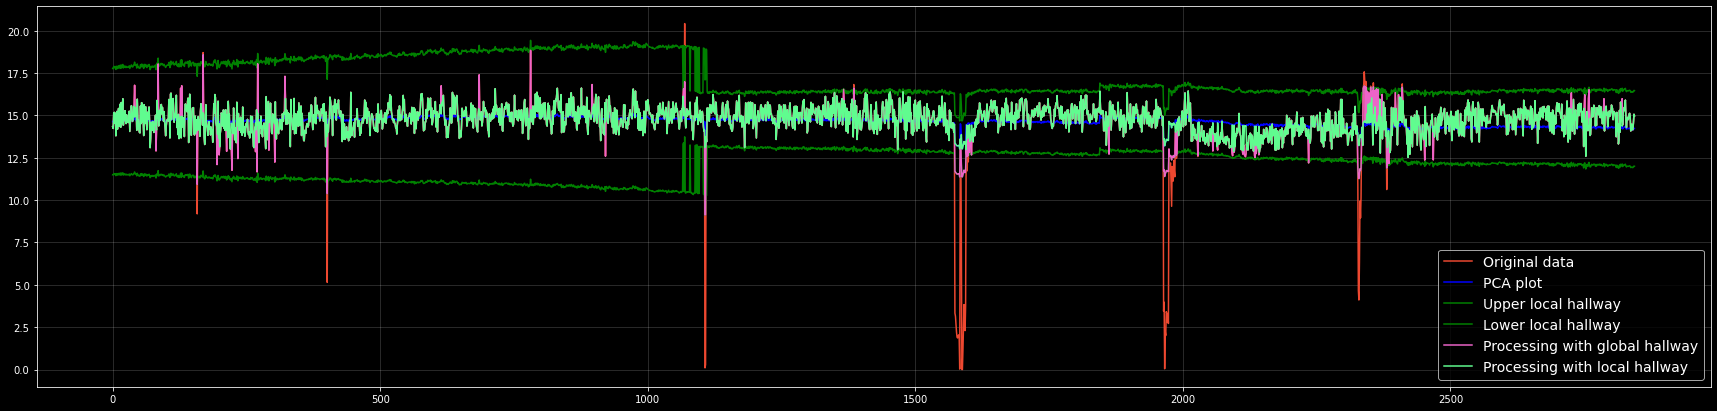

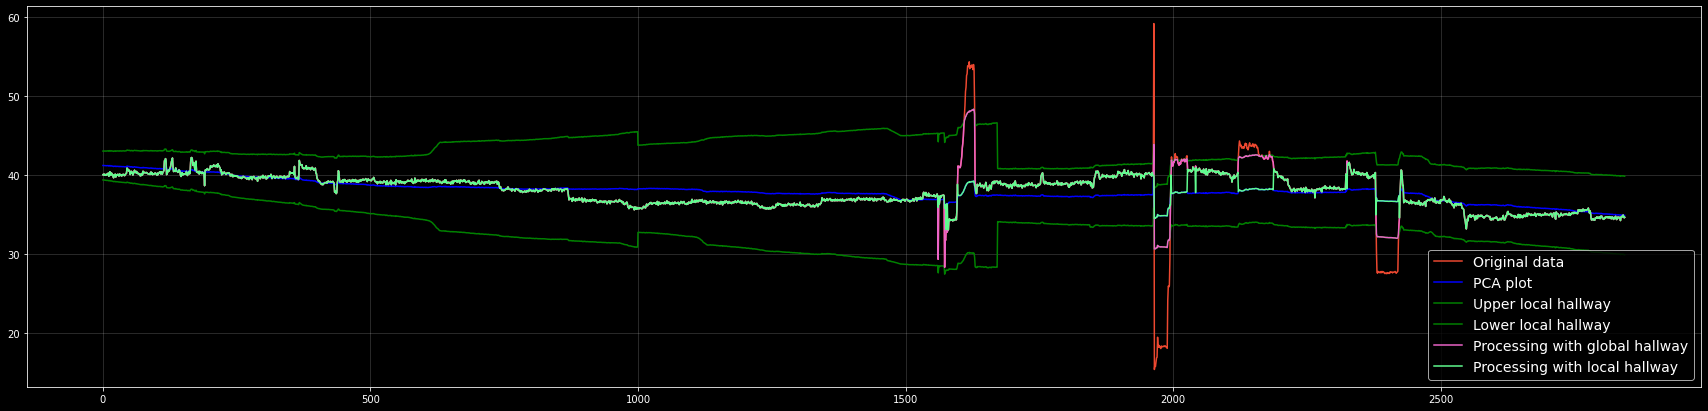

In [23]:
df_total = pd.read_csv('C:/Users/exore/Downloads/Telegram Desktop/stirol.csv', sep=';', header=None)

#t1 = time.time()
process(column=-1, window=1000, stop_fraction=0.01, hallway_length='std', hall_rise=True)
process(column=1, window=1000, stop_fraction=0.01, hallway_length='std', hall_rise=True)
#print("Global time: ", time.time() - t1)

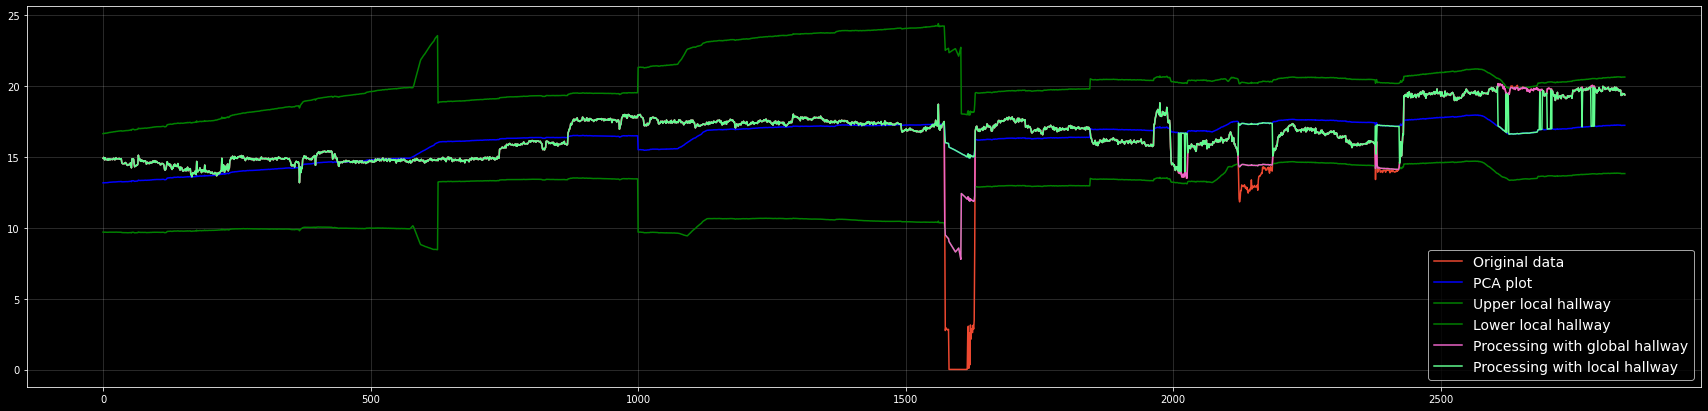

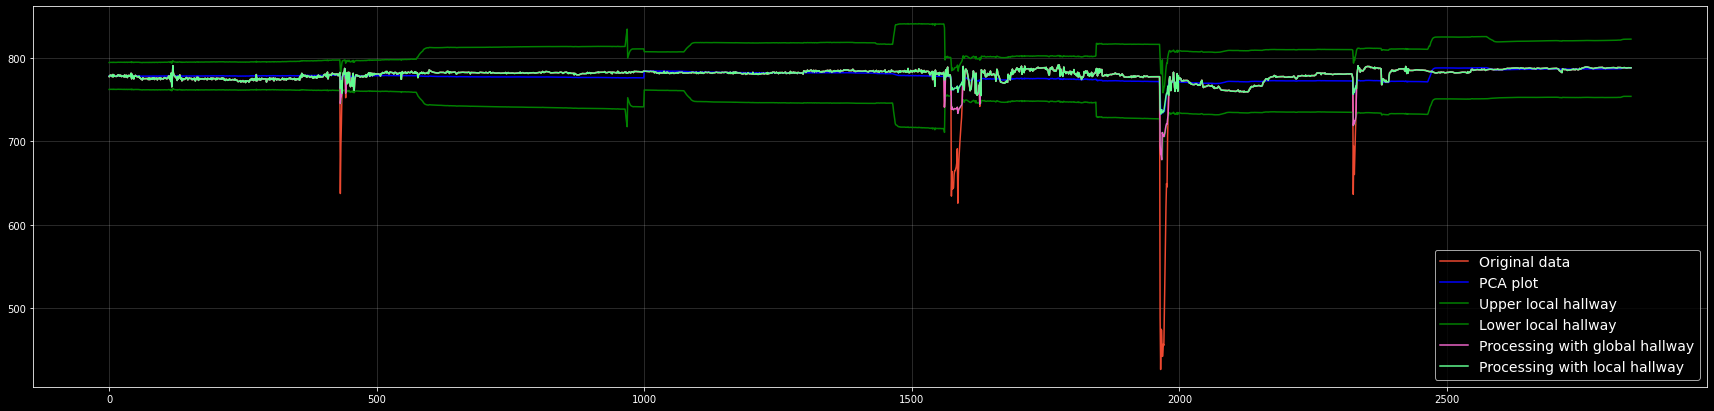

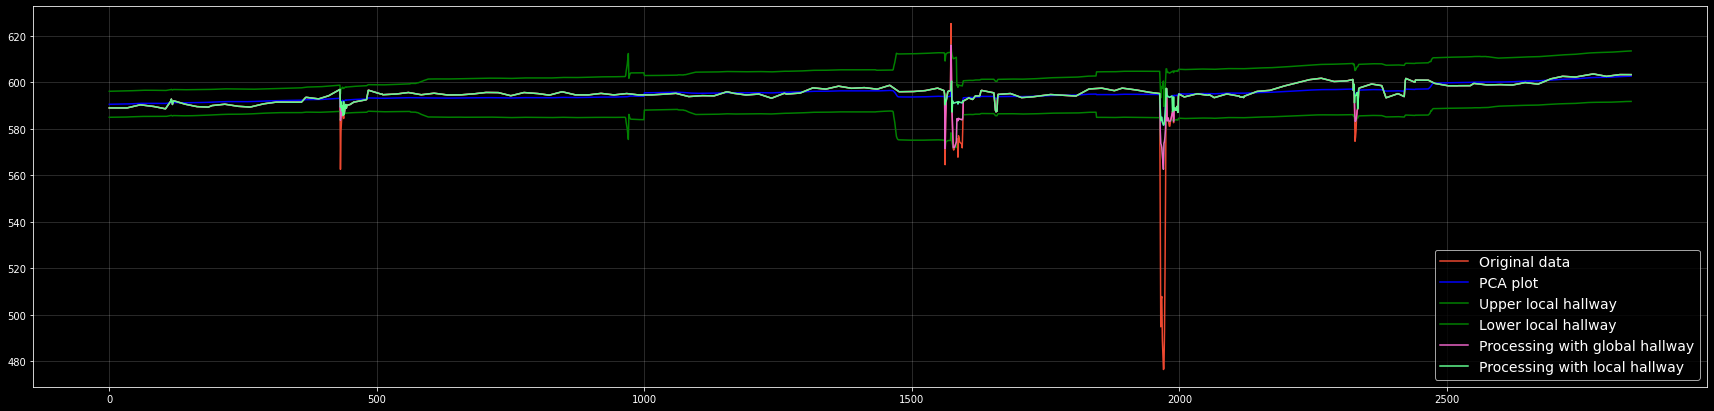

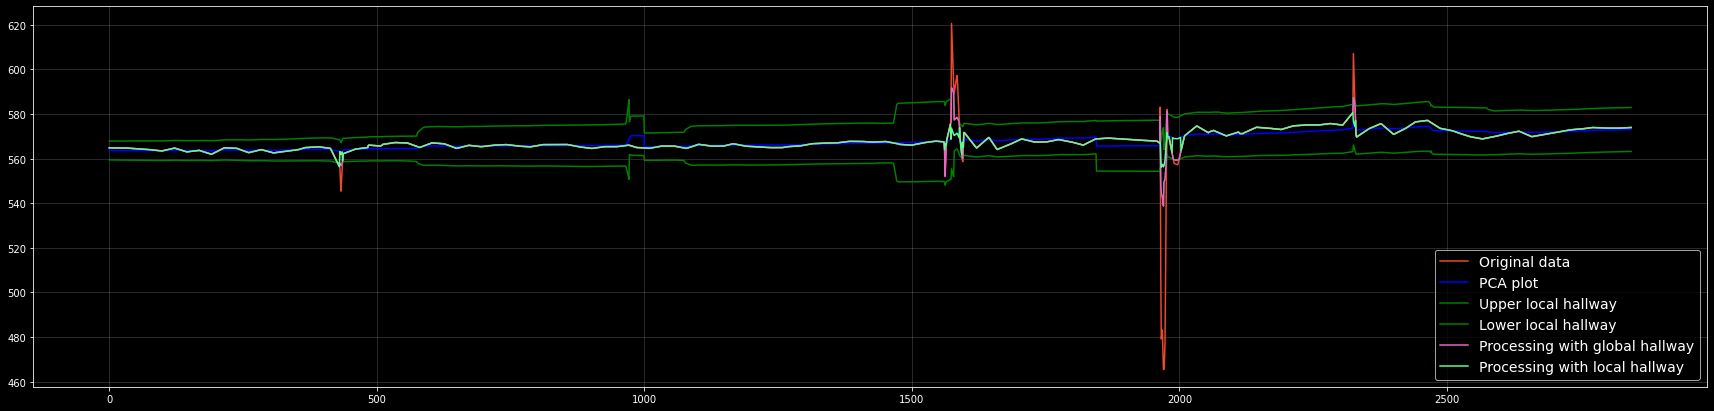

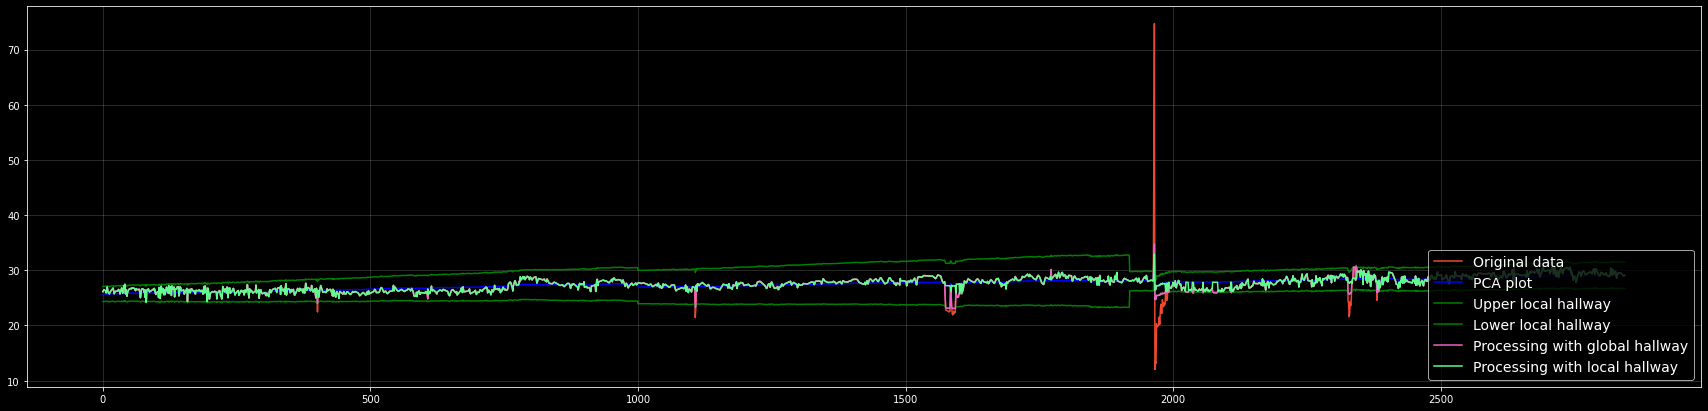

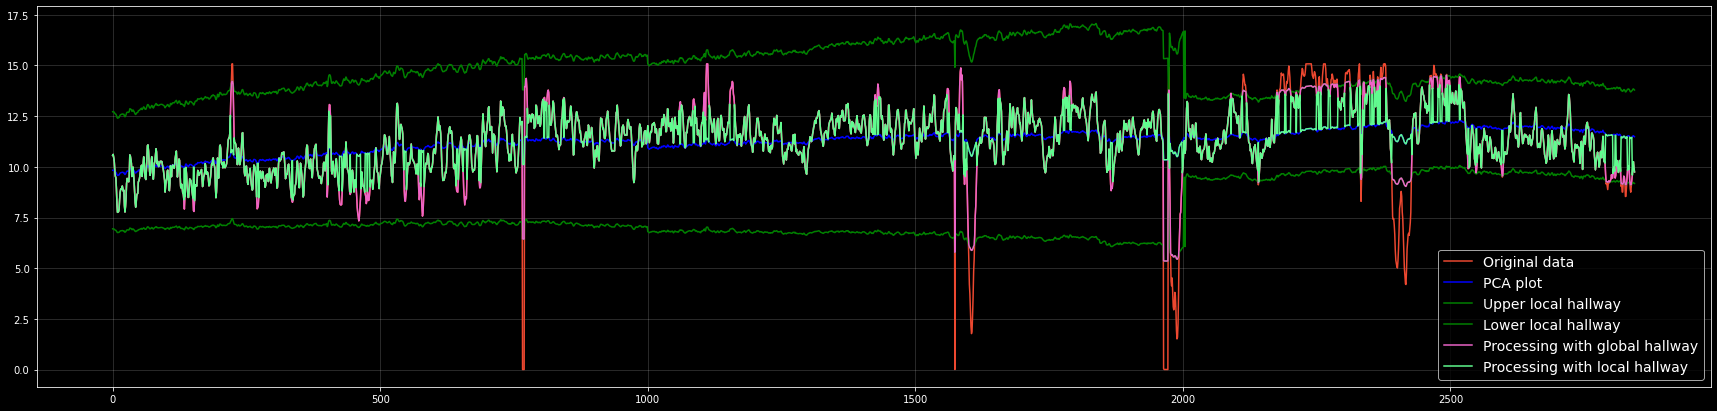

In [25]:
for column in [0, 4, 5, 10, -5, -2]:
    process(column=column, window=1000, stop_fraction=0.01, hallway_length='std', hall_rise=True)

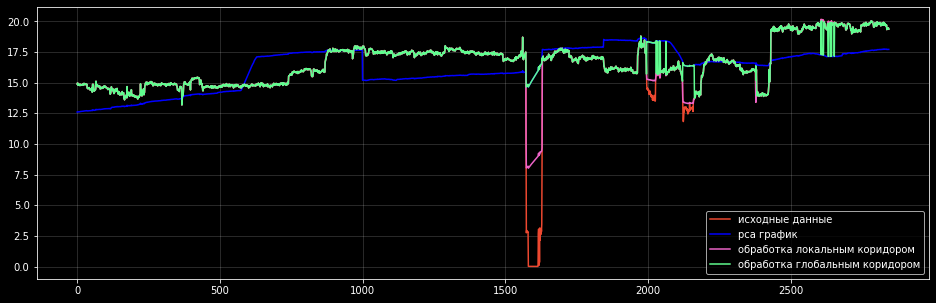

0


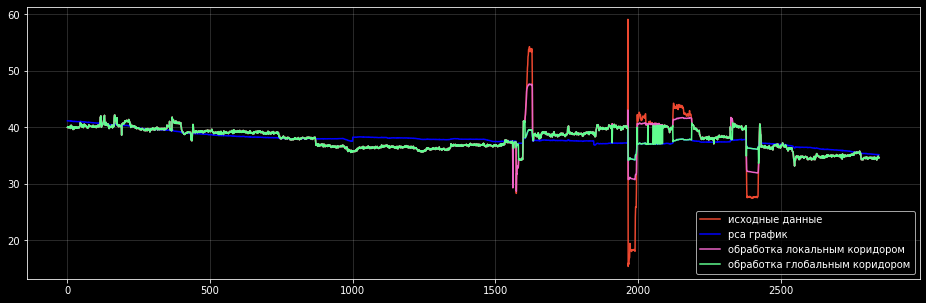

1


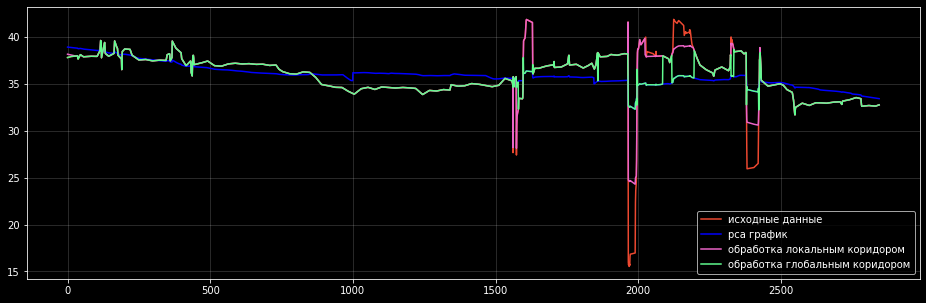

2


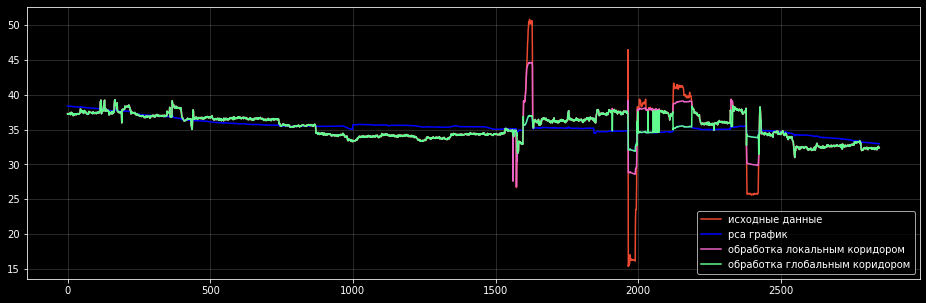

3


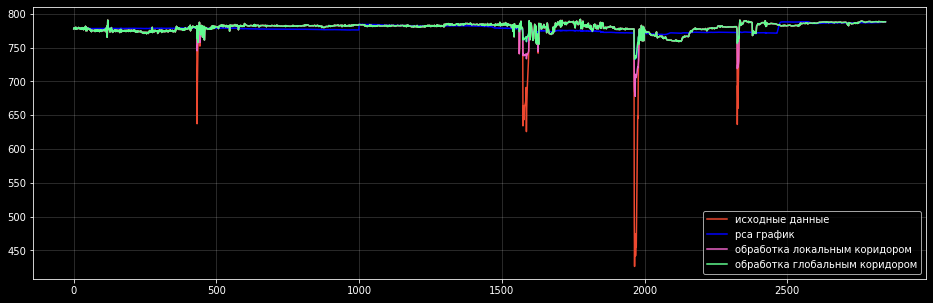

4


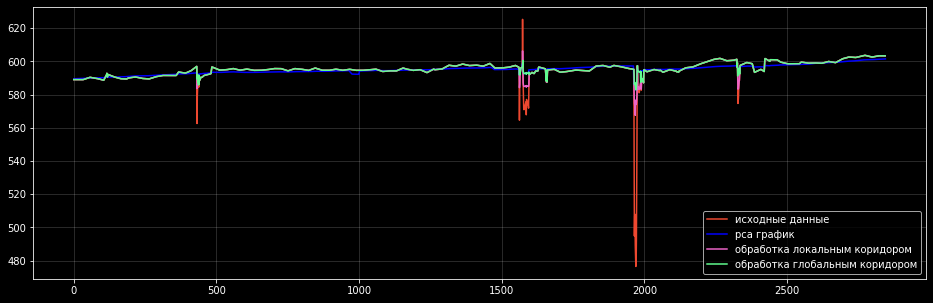

5


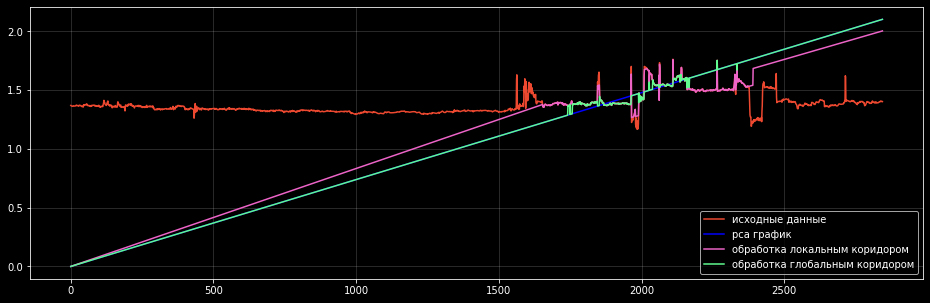

6


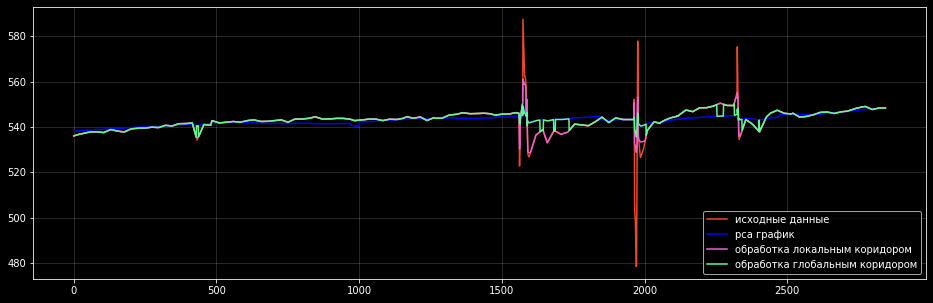

7


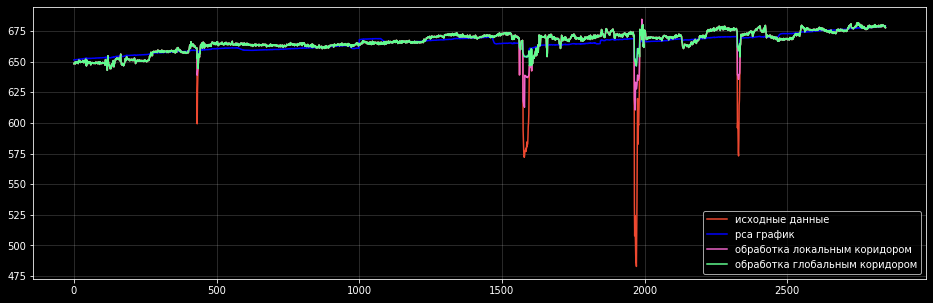

8


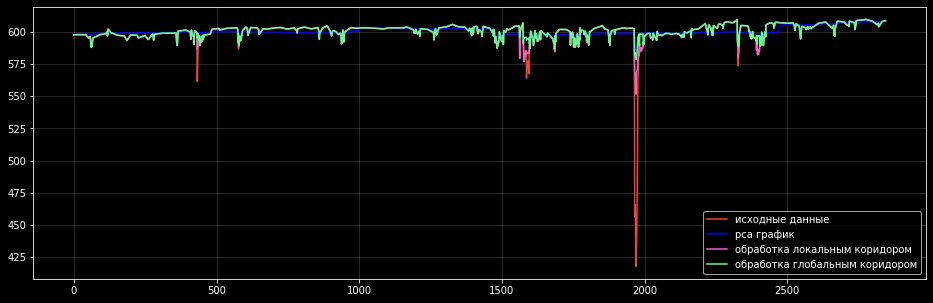

9


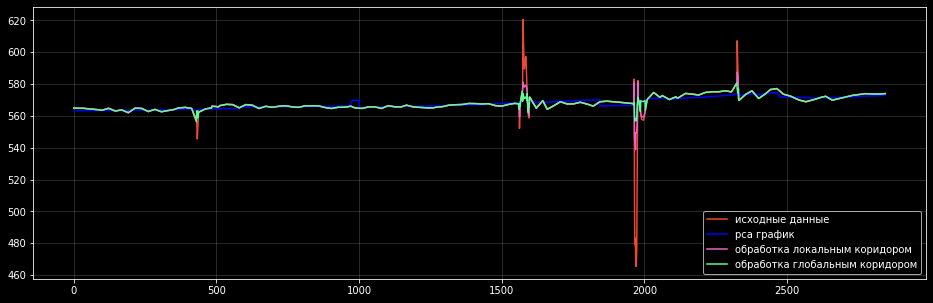

10


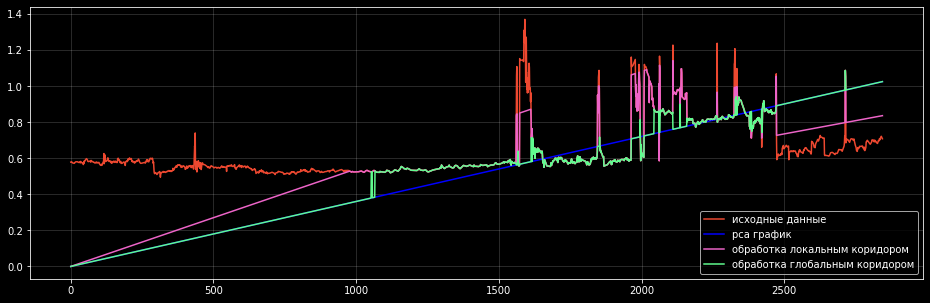

11


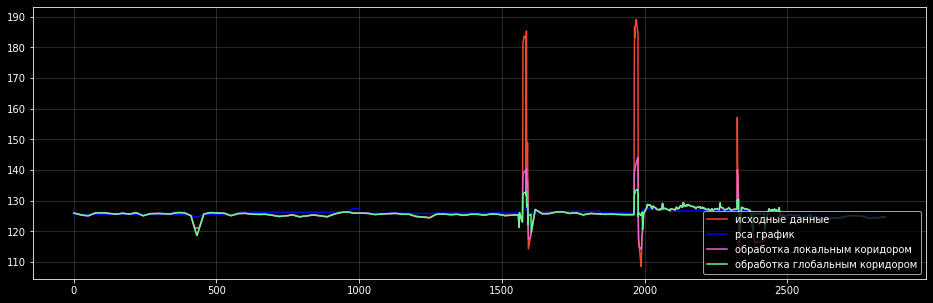

12


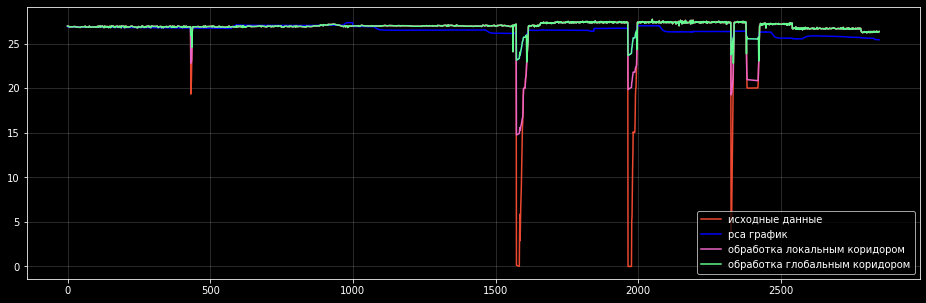

13


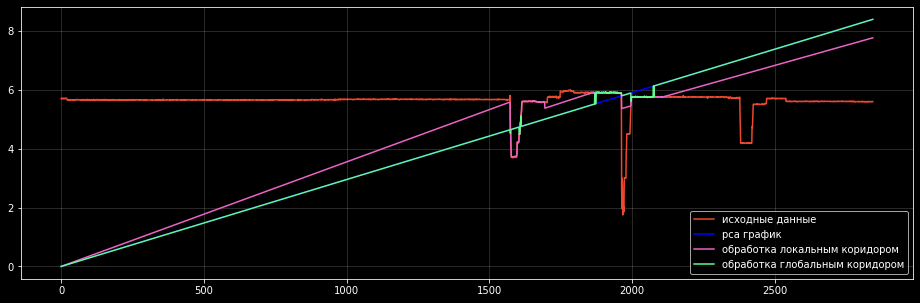

14


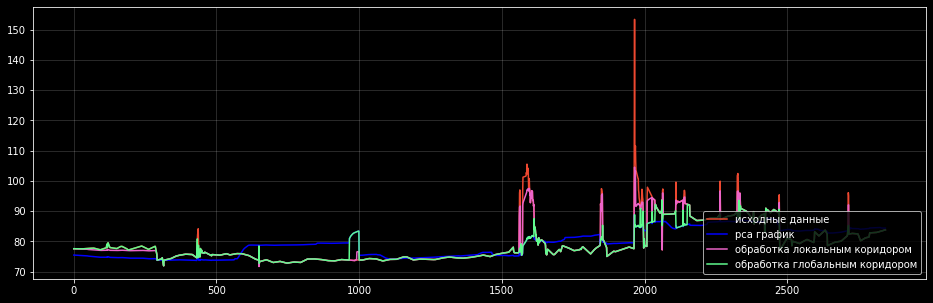

15


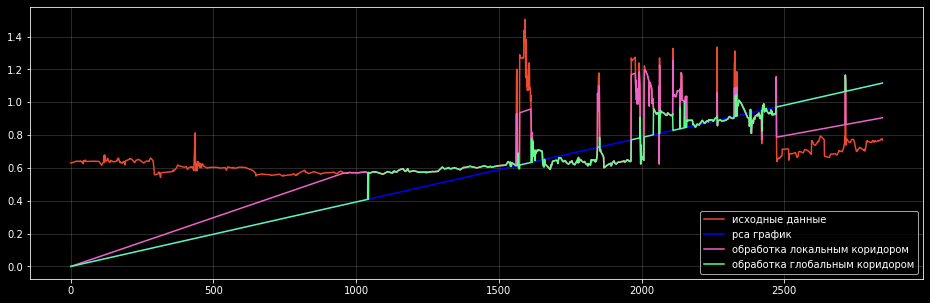

16


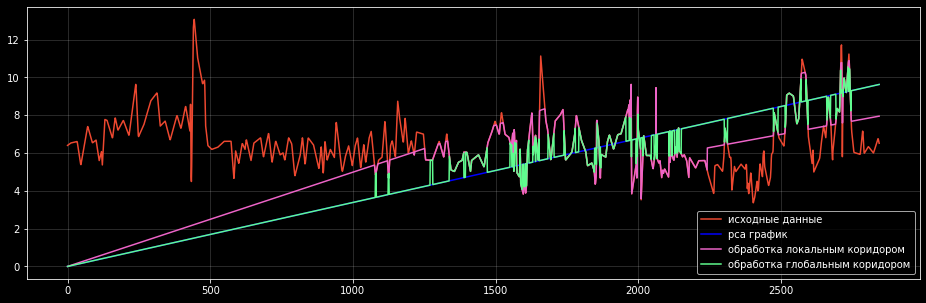

17


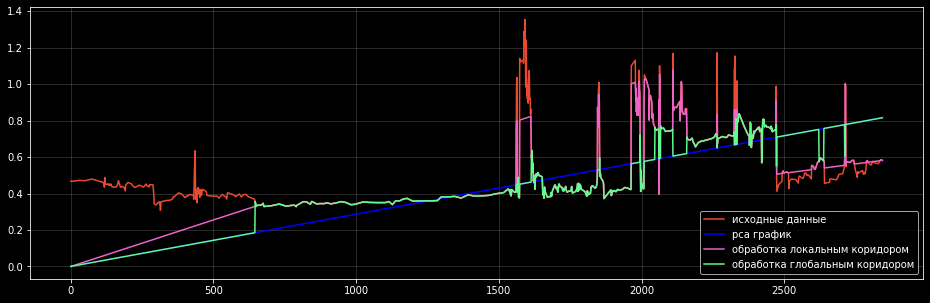

18


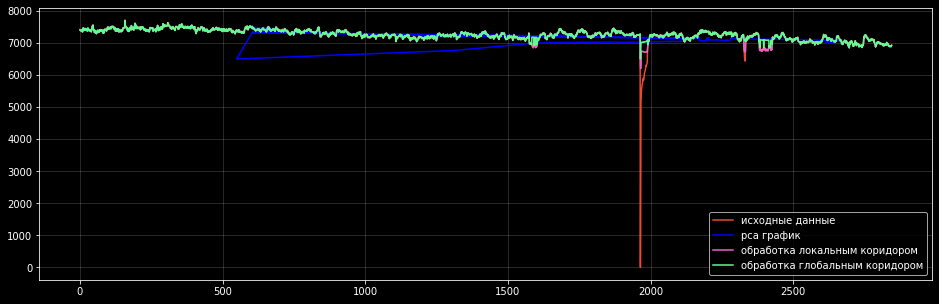

19


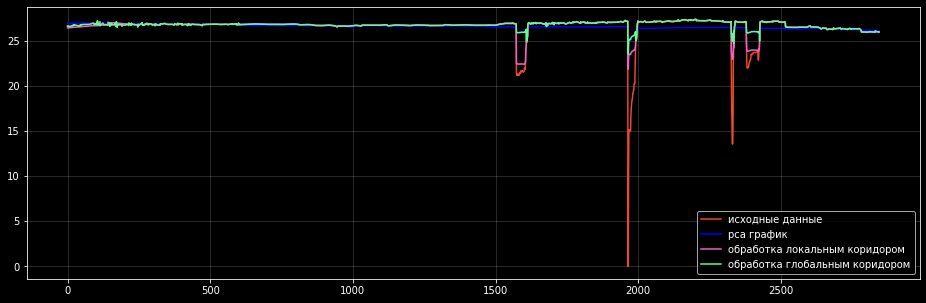

20


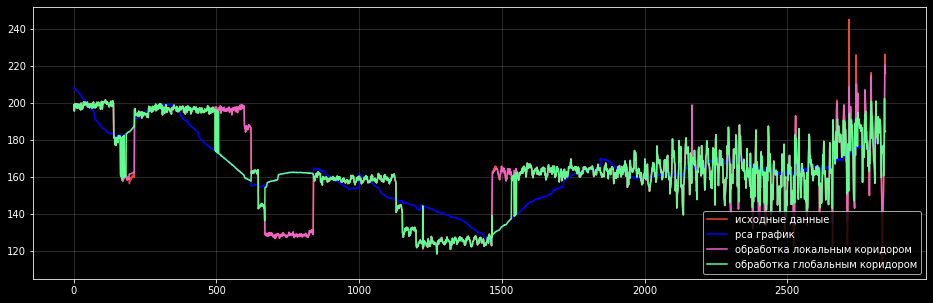

21


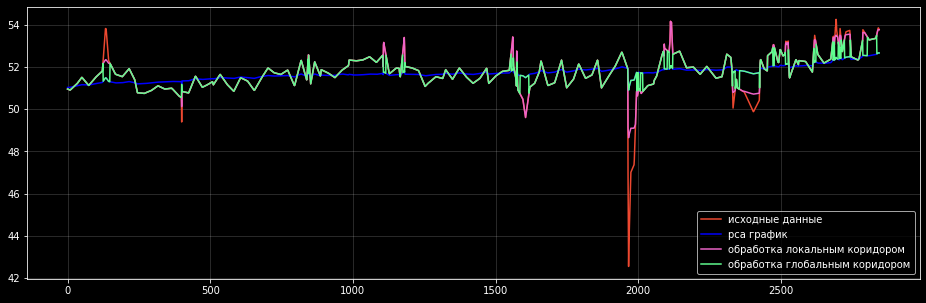

22


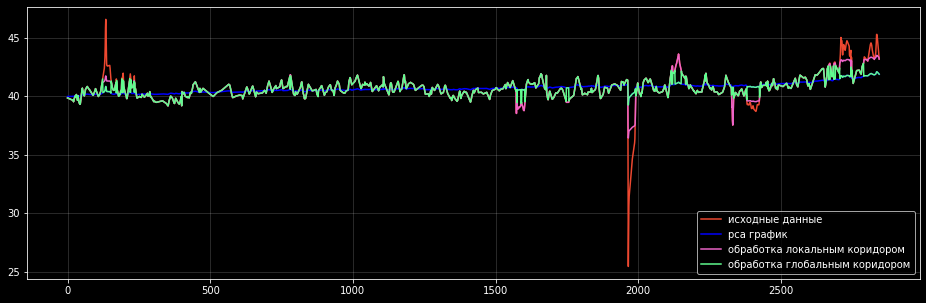

23


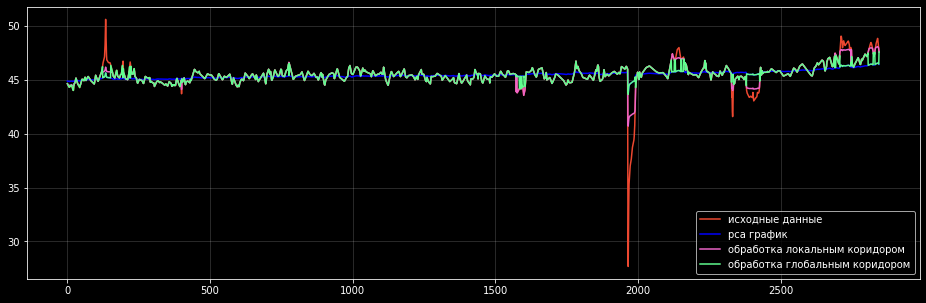

24


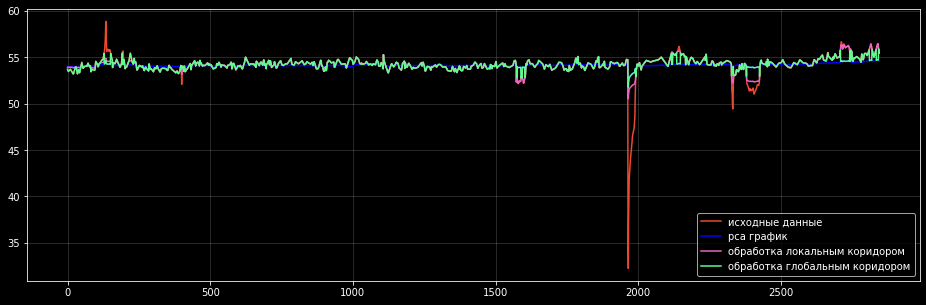

25


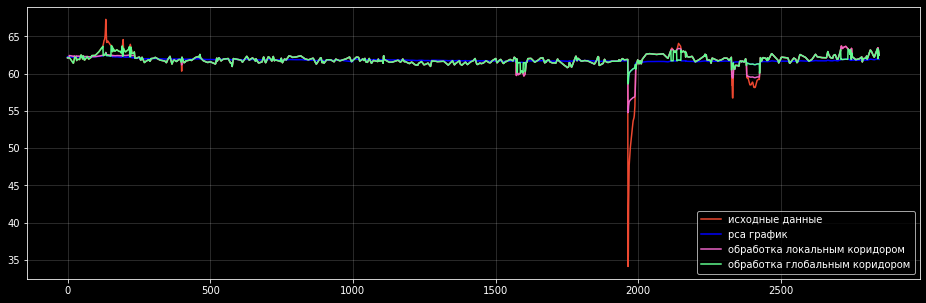

26


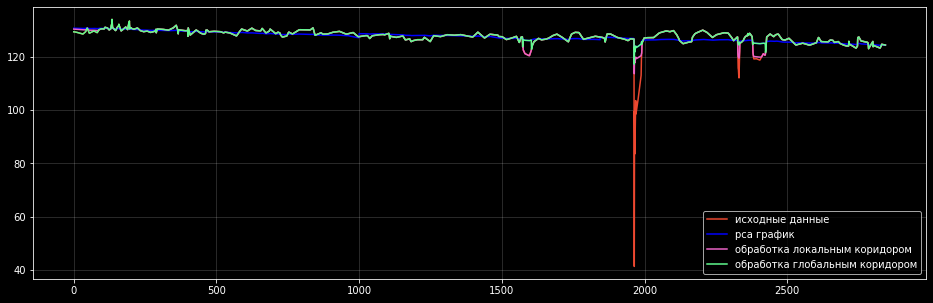

27


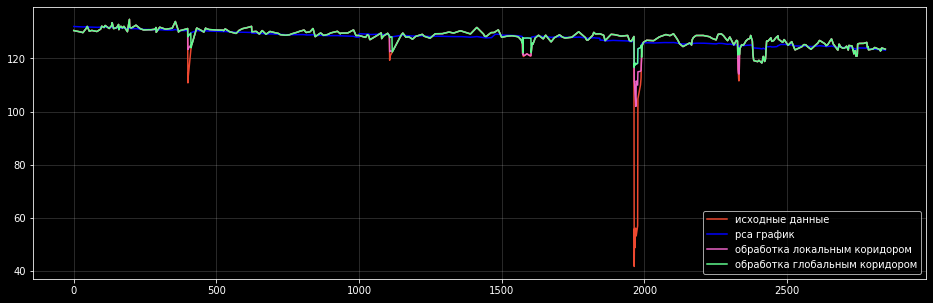

28


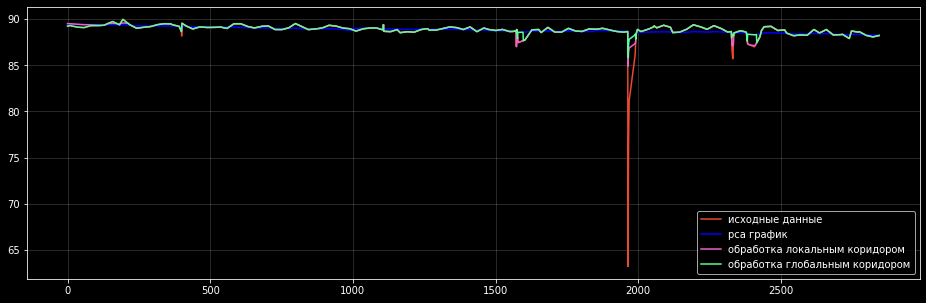

29


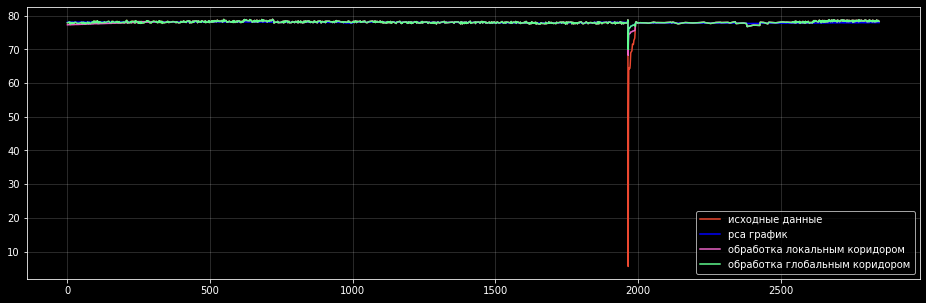

30


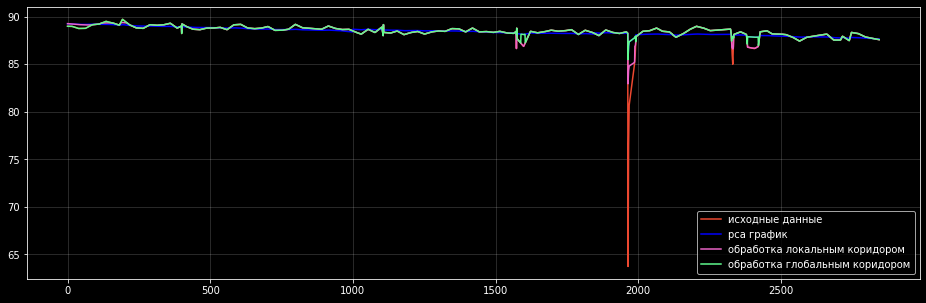

31


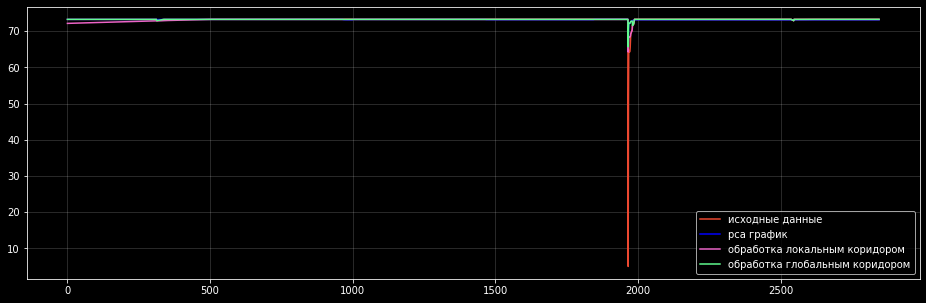

32


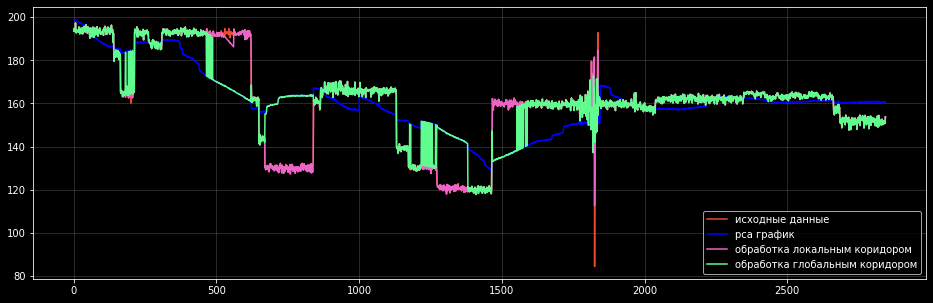

33


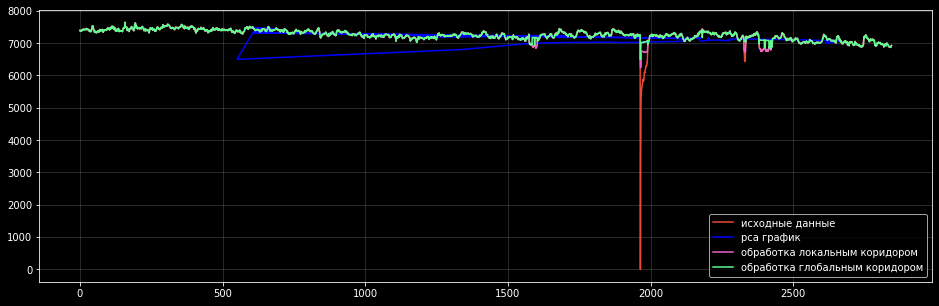

34


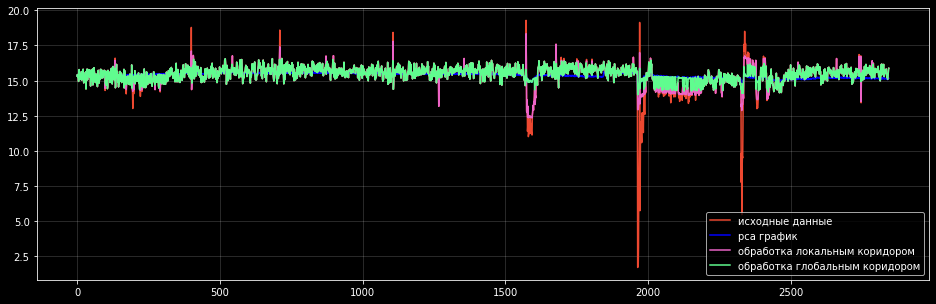

35


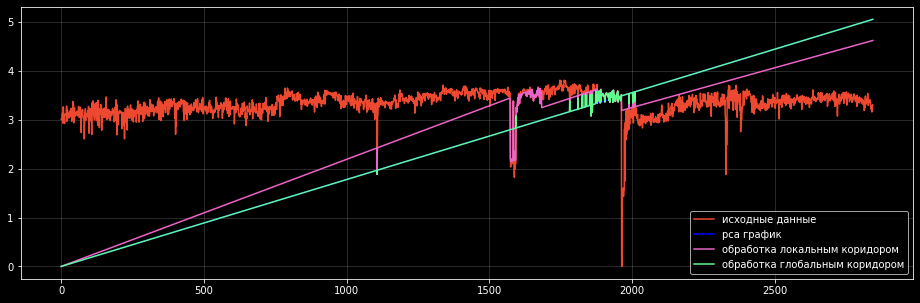

36


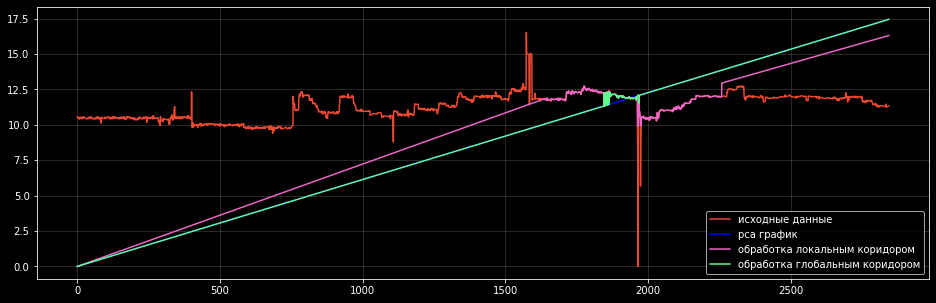

37


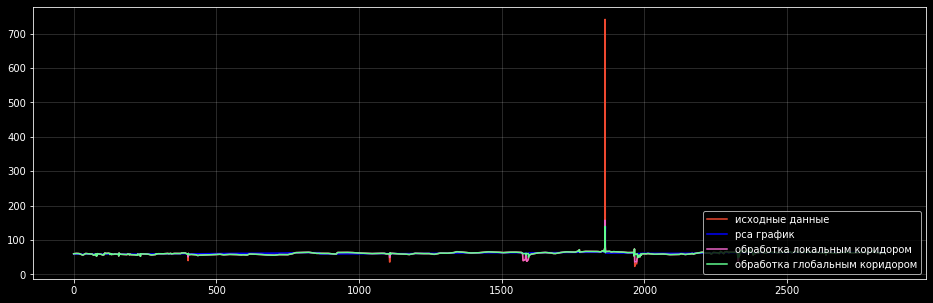

38


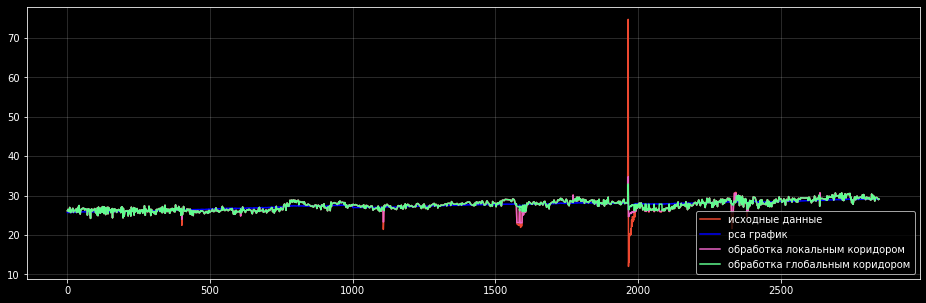

39


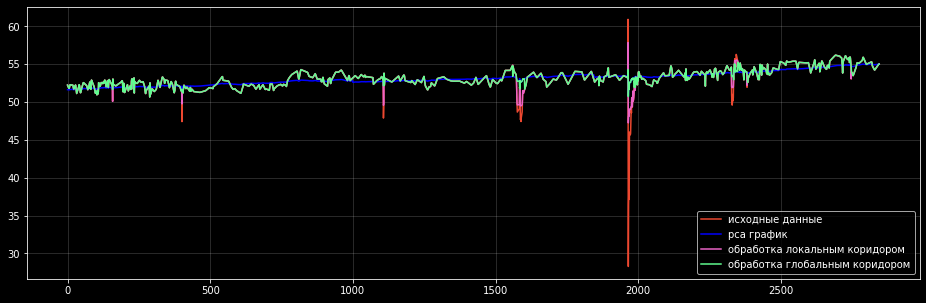

40


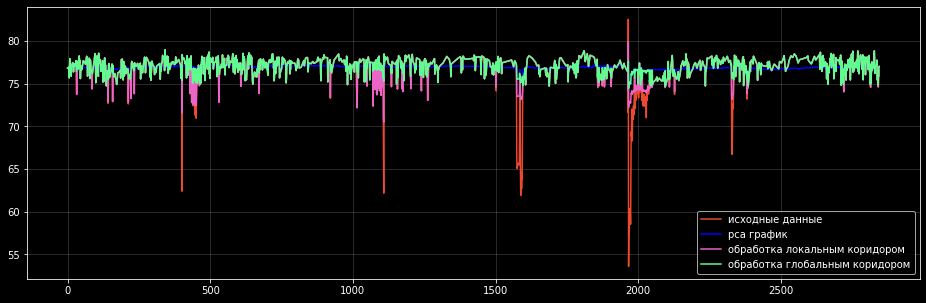

41


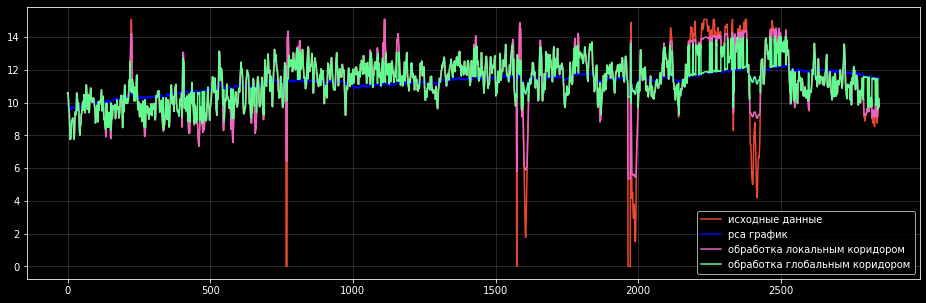

42


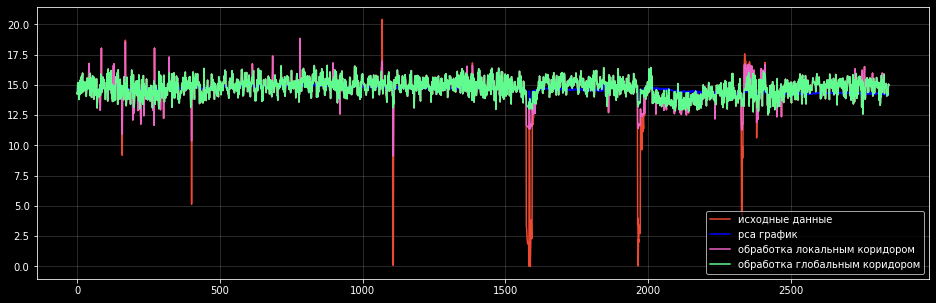

43


In [40]:
for i in range(44):
    t1 = time.time()
    process(column=i, window=1000, stop_fraction=0.01, hallway_length='std', hall_rise=True)
    print(i)
    time_array.append(time.time() - t1)

In [41]:
time_array = np.array(time_array)
time_array.var(), time_array.mean(), np.median(time_array), np.std(time_array)

(0.004368144568694049,
 1.468607037675147,
 1.4491310119628906,
 0.06609194027030868)